In [1]:
import os
#os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=12'

from brax import envs
from brax.training import distribution
#from brax.training import env
from brax.training import networks

import flax
from flax import linen as nn
import jax
import jax.numpy as jnp
from brax.envs import create_fn

from IPython.display import HTML, clear_output
from brax.io import html

import optax

import matplotlib.pyplot as plt
import numpy as np
from brax.training import ppo
from brax.io import model

from functools import partial

import optax

jax.config.update('jax_platform_name', 'cpu')

def visualize(sys, qps, height=480):
  """Renders a 3D visualization of the environment."""
  return HTML(html.render(sys, qps, height=height))

jax.devices()

In [3]:
episode_length = 500
action_repeat = 1
batch_size = jax.local_device_count()
noise_std = 0.2

noise_scale = 2.0
noise_beta = 2.0

apg_epochs = 250
normalize_observations=True

env_name = "acrobot"  # @param ['ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'walker2d, 'ur5e', 'reacher', bball_1dof]
env_fn = create_fn(env_name = env_name, action_repeat=action_repeat, auto_reset=False)
env = env_fn()

In [4]:
import brax.jumpy as jp
@jax.jit
def do_rnn_rollout(key):
    init_state = env.reset(key)
    h0 = jp.zeros_like(init_state.obs)

    def do_one_rnn_step(carry, step_idx):
        (state,) = carry
        actions = jp.ones((2,))*1.0
        nstate = env.step(state, actions)    
        return (nstate,), (nstate.reward, state.obs, actions, nstate)


    _, (rewards, obs, acts, states) = jp.scan(
        do_one_rnn_step, (init_state,),
        (jnp.array(range(episode_length // action_repeat))),
        length=episode_length // action_repeat)

    return rewards, obs, acts, states

nan


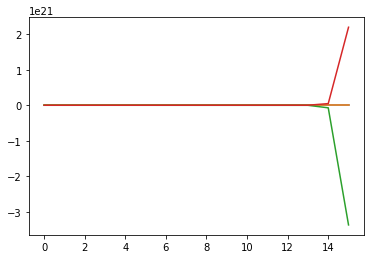

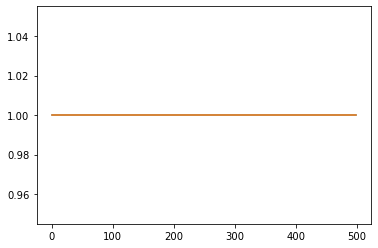

In [7]:
reset_key = jax.random.PRNGKey(0)
(rewards, obs1, acts1, states1) = do_rnn_rollout(reset_key)
plt.plot(obs1);
plt.figure()
plt.plot(acts1);
print(sum(rewards))

In [15]:
qp_flat, qp_def = jax.tree_flatten(states.qp)

qp_list = []

for i in range(qp_flat[0].shape[0]):
    qpc=[]
    for thing in qp_flat:
        qpc.append(thing[i,:])
    qp_list.append(jax.tree_unflatten(qp_def, qpc))
    

visualize(env.sys, qp_list, height=800)

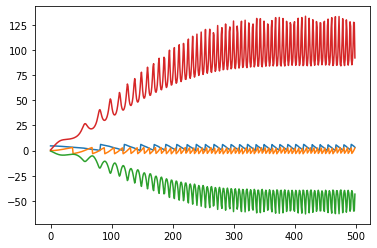

In [29]:
import seagul.envs
import gym

env2 = gym.make('su_acrobot-v0')
o = env2.reset()

obs2 = []
for i in range(500):
    a = np.ones(1)*25
    o,r,d,_ = env2.step(a)
    obs2.append(o)
    
obs2 = np.stack(obs2)
plt.plot(obs2)
    


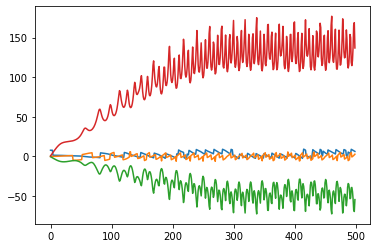

In [31]:
plt.plot(obs2 - obs1)